In [64]:
import sys
import os
import time
import matplotlib.pyplot as plt
sys.path.append(".")
sys.path.append("..")

from algorithms.old_path_planning import OldPathPlanner
from algorithms.path_planning import PathPlanner, stanley_smooth_path
from algorithms.optimized_path_planning import stanley_smooth_path as optimized_smooth_path
from algorithms.david_planning import PathPlanner as DavidPathPlanning, stanley_smooth_path as david_smooth

from tvojemama.logger import LogReader

import torch
from torch import optim

## Gather data from log

In [33]:
log_path = "/home/snake/eforce/bros/data/bros_logs/05_05_2023-07_09_13/AS/mission_05_05_2023-07_09_13.pkl"
log_reader = LogReader(log_path)

1076.087575196 1076.100148199


In [34]:
period = 0.05 # time between percep_data samples in seconds

percep_datas = []

counter = 0
start_time = None
for msg_t, (msg_name, data) in log_reader:
    
    mission_kwargs = data['mission_kwargs']
    percep_data = mission_kwargs['percep_data']
    
    if start_time is None:
        start_time = msg_t
        
    curr_msg_t = msg_t - start_time
        
    if curr_msg_t / period >= counter:
        counter += 1
        
        if percep_data.shape[0] != 0:
            percep_datas.append(percep_data)
    
print(f"got {len(percep_datas)} samples")

got 945 samples


## Run tests

In [35]:
def benchmark_path_planning(find_path_fn, smooth_fn=None):
    indiv_times = []
    start_time = time.time()
    for percep_data in percep_datas:
        curr_start_time = time.time()
        path = find_path_fn(percep_data)
        
        if smooth_fn is not None:
            path = smooth_fn(path)
            
        curr_end_time = time.time()
        indiv_times.append(curr_end_time - curr_start_time)
    end_time = time.time()
    
    print(f"took {end_time - start_time:.2f} seconds")
    print(f"\tMean time: {((end_time - start_time) / len(percep_datas) * 1000):.3f} ms")
    print(f"\tMax time: {max(indiv_times) * 1000:.3f} ms")
    print(f"\tMin time: {min(indiv_times) * 1000:.3f} ms")

In [36]:
# initializing
path_planner = PathPlanner()
old_path_planner = OldPathPlanner({"n_steps": 20})
david_planner = DavidPathPlanning()

In [37]:
benchmark_path_planning(find_path_fn=path_planner.find_path, smooth_fn=stanley_smooth_path)

took 9.79 seconds
	Mean time: 10.356 ms
	Max time: 25.243 ms
	Min time: 3.186 ms


In [38]:
benchmark_path_planning(find_path_fn=path_planner.find_path, smooth_fn=None)

took 4.56 seconds
	Mean time: 4.829 ms
	Max time: 16.403 ms
	Min time: 0.675 ms


In [39]:
benchmark_path_planning(find_path_fn=old_path_planner.find_path, smooth_fn=None)

took 0.80 seconds
	Mean time: 0.846 ms
	Max time: 4.024 ms
	Min time: 0.147 ms


In [40]:
benchmark_path_planning(find_path_fn=old_path_planner.find_path, smooth_fn=optimized_smooth_path)

took 5.29 seconds
	Mean time: 5.596 ms
	Max time: 50.372 ms
	Min time: 1.886 ms


In [41]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=david_smooth)

took 4.82 seconds
	Mean time: 5.098 ms
	Max time: 11.137 ms
	Min time: 2.267 ms


In [42]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=None)

took 0.61 seconds
	Mean time: 0.645 ms
	Max time: 1.961 ms
	Min time: 0.242 ms


## Custom solution

In [130]:
def torch_smooth_path(path, use_spline_as_smoother=False, add_more_points_to_path=False):

    def normalize(v):
        # norm = np.linalg.norm(v, axis=0) + 0.00001
        norm = torch.norm(v, dim=0) + 0.00001
        return v / norm  # .reshape(1, v.shape[1])

    def curvature(waypoints):
        '''
        Curvature as  the sum of the normalized dot product between the way elements
        Implement second term of the smoothing objective.

        args:
            waypoints [2, num_waypoints] !!!!!
        '''
        shift_left = torch.roll(waypoints, shifts=-1, dims=1)
        shift_right = torch.roll(waypoints, shifts=1, dims=1)
        left_half = normalize(shift_left - waypoints)
        right_half = normalize(waypoints - shift_right)
        mul = left_half * right_half
        segment = torch.sum(mul, dim=0)
        return torch.sum(segment[1:-1])

    def smoothing_objective(waypoints, waypoints_center, weight_curvature=16):  # weight_curvature=128
        '''
        Objective for path smoothing

        args:
            waypoints [2 * num_waypoints] !!!!!
            waypoints_center [2 * num_waypoints] !!!!!
            weight_curvature (default=40)
        '''
        waypoints = waypoints.reshape(-1, 2)
        waypoints_center = waypoints_center.reshape(-1, 2)
        ls_tocenter = torch.sum(torch.square(waypoints - waypoints_center))
        ls_curvature = curvature(waypoints.T)
        boundary_penalty = 0  # ? TODO? F_rddf in Stanley paper
        return ls_tocenter - weight_curvature * ls_curvature + boundary_penalty

    initial_trajectory = torch.tensor(path, dtype=torch.float32, requires_grad=True)
    initial_trajectory_gt = initial_trajectory.clone()
    
#     optimizer = optim.Adam([initial_trajectory], lr=0.1)
    optimizer = optim.SGD([initial_trajectory], lr=0.01)
    num_iterations = 1
    
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        cost = smoothing_objective(initial_trajectory, initial_trajectory_gt)
        
        cost.backward()
        optimizer.step()

    optimized_trajectory = initial_trajectory.detach().numpy()
    smooth_path = optimized_trajectory.reshape(-1, 2)
    smooth_path[0] = [0., 0.]  # TODO:Fix this ?add constraint to minimize?
    return smooth_path

In [131]:
cones = percep_datas[310]
path = david_planner.find_path(cones)
smoother_path = torch_smooth_path(path)

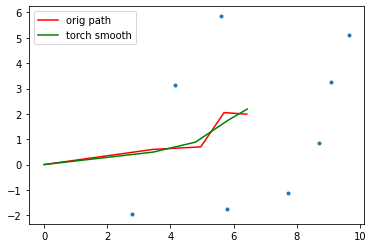

In [132]:
plt.plot(cones[:,0], cones[:,1], '.')
plt.plot(path[:,0], path[:,1], '-', color='red' ,label='orig path')
plt.plot(smoother_path[:,0], smoother_path[:,1], '-', color='green', label='torch smooth')
plt.legend()
plt.show()

In [133]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=torch_smooth_path)

took 1.15 seconds
	Mean time: 1.221 ms
	Max time: 2.988 ms
	Min time: 0.787 ms
